In [50]:
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel


import pandas as pd
import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Random Forest Regressor

## Prediction

In [243]:
X = np.linspace(0,100)
Y = [x**2 + stats.norm.rvs()*10*x for x in X]


In [244]:
# create regressor object 
regressor = RandomForestRegressor(n_estimators = 100) 
  
# fit the regressor with x and y data 
regressor.fit([[x] for x in X], [[y] for y in Y]) 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [306]:
Y_pred = [regressor.predict([[x]]) for x in X]
Y_pred = [p[0] for p in Y_pred]

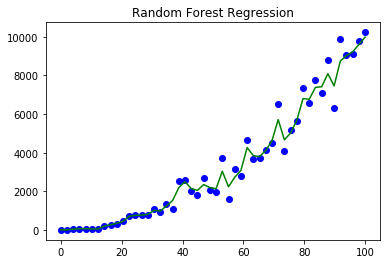

In [307]:
  
plt.scatter(X, Y, color = 'blue')   
  
# plot predicted data 
plt.plot(X, Y_pred,  
         color = 'green')  
plt.title('Random Forest Regression') 
plt.show()

## Imputing Missing Values

#### We load omics data ( in this case stolen from https://www.ncbi.nlm.nih.gov/pubmed/26004780 )

In [249]:
df = pd.read_csv("data/scRNAseq.tsv", sep="\t", index_col=0, header=0)
print (df.shape)

(37315, 96)


In [250]:
# To those genes that are almost always zero we exclude them
df = df[df.eq(0).sum(1)<66]
print (df.shape)

(7748, 96)


In [251]:
# We will try to impute zeros for one specific gene: Xpo6 (choosen randomly by me)
corr_matrix = df.T.corr()

In [308]:
corr_matrix.shape

(7748, 7748)

In [252]:
# I will select as independent those with abs(corr) < 0.2
dependent = []
for gene,value in (abs(corr_matrix.loc["Xpo6"]) > 0.2).iteritems():
    if value == True:
        dependent.append(gene)
        
print (len(dependent))

240


In [298]:
# First, which are the genes that are not independent of this one? (aka the ones that will help us to impute values)

indices = np.random.permutation(df.shape[1])
cut = 66 # cells for training, 30 for testing, manually stablished

#split the random permutation into two parts
training_idx, test_idx = indices[:cut], indices[cut:]

#Training and test sets to two separated matrices
training, test = df.loc[dependent].iloc[:,training_idx], df.loc[dependent].iloc[:,test_idx]

#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
#Create tree object
model = RandomForestRegressor(n_jobs=100)

# Of the training set, we cut out the dependent genes
tmp = df.loc[dependent,:]
y = tmp.iloc[training_idx]

# SelectFromModel is a transforming class that allow us to pick the most 
# important features (in this case, those genes that are important to predict our gene)
sfm = SelectFromModel(model)
# Fit is always to accomodate the data, in this case just considering the most important features
# We are transposing, because in this case we are taking as features the genes and not the cells!!
sfm.fit(training.T, y)
# This returns true or false just and then select the important genes in features_idx
feature_idx = sfm.get_support(indices=True)

model = RandomForestRegressor(oob_score = True, n_jobs = 100) #n_estimators = 100

#Train the model using the training sets
model.fit(training.iloc[feature_idx].T, y.iloc[:,training_idx].T["Xpo6"])

#Predict Output for our gene
predicted= model.predict(test.iloc[feature_idx].T)

print(predicted)
print (stats.pearsonr(predicted, test.loc["Xpo6"] ))

[38.864   9.7652  9.0046 13.1967  0.289   6.9244 12.6035  0.6592  9.846
 12.7469 13.8914  5.8632 21.5285 13.8219  7.5533  2.6788  4.168  24.889
  5.1174  3.2027 18.9847  1.8903  4.3478  6.2967  0.302  30.6018  9.0152
  2.6201 11.5311  6.3426]
(0.5182514249392545, 0.0033491693865631044)


### Some dimensionalities to look at

In [288]:
df.loc[dependent].iloc[:,training_idx].iloc[feature_idx].shape, y.iloc[:,training_idx].T["Xpo6"].shape

((48, 66), (66,))

### Plot original values vs imputed ones
#### We have good correlation for those values that were non-zero, and a lot of zero values we have fullfiled them.


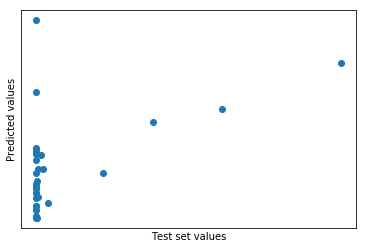

In [305]:
fig,ax = plt.subplots(1)
ax.set_xlabel("Test set values")
ax.set_ylabel("Predicted values")
plt.plot(test.loc["Xpo6"],predicted, "o")

# Ensemble of Classifiers

In [13]:
df = pd.read_csv("data/airbnb.csv", sep=",", header=0)

training_df = df.loc[random.sample(list(df.index), 4000)]
print(training_df.shape)

predict_df = df.loc[random.sample(list(df.index), 1000)]
predict_df.shape

(4000, 16)


(1000, 16)

In [14]:
estimators = [ ('rf', RandomForestClassifier(n_estimators=100)), \
               ('svr', DecisionTreeClassifier()), \
               ('nbc', GaussianNB())]

clf = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(n_estimators=100) )


In [16]:
training_features = training_df[["latitude","longitude"]]
training_labels = training_df[["neighbourhood_group"]]

to_predict_features = predict_df[["latitude","longitude"]]
to_predict_labels = predict_df[["neighbourhood_group"]]

clf.fit(training_features, training_labels).score(to_predict_features, to_predict_labels)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.982